Aluna: Manuela de Lacerda Bezerra Carvalho (mlbc@cesar.school)

In [ ]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-12-19 17:00:42--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  33.4MB/s    in 3.5s    

2024-12-19 17:00:46 (30.3 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [ ]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 15.67it/s]


Epoch 1, Train Loss: 2.324, Train Accuracy: 8.20%
Epoch 1, Val Loss: 2.252, Val Accuracy: 17.40%


100%|██████████| 16/16 [00:00<00:00, 22.98it/s]


Epoch 2, Train Loss: 2.184, Train Accuracy: 25.70%
Epoch 2, Val Loss: 2.025, Val Accuracy: 46.00%


100%|██████████| 16/16 [00:00<00:00, 22.78it/s]


Epoch 3, Train Loss: 1.692, Train Accuracy: 46.10%
Epoch 3, Val Loss: 1.065, Val Accuracy: 70.20%


100%|██████████| 16/16 [00:00<00:00, 16.81it/s]


Epoch 4, Train Loss: 0.915, Train Accuracy: 68.10%
Epoch 4, Val Loss: 0.575, Val Accuracy: 81.40%


100%|██████████| 16/16 [00:01<00:00, 15.92it/s]


Epoch 5, Train Loss: 0.590, Train Accuracy: 80.10%
Epoch 5, Val Loss: 0.422, Val Accuracy: 85.60%
Treinamento concluído


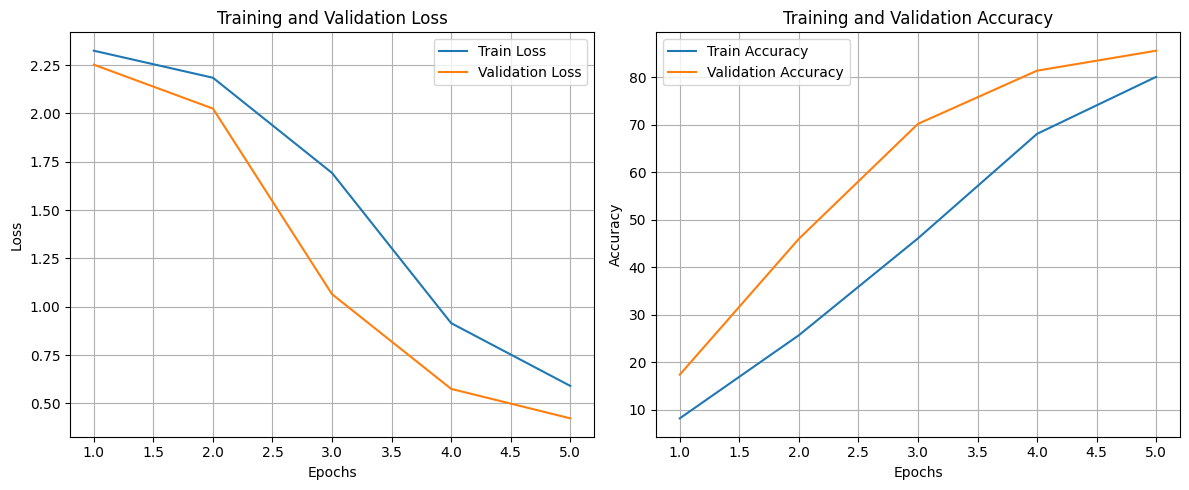

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 86.80%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [ ]:
class CNN_1(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

model_1 = CNN_1(initialize_weights=True, dropout=0.2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9)

history = train_model(
    model=model_1,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

test_model(model_1, testloader)

100%|██████████| 16/16 [00:00<00:00, 22.44it/s]


Epoch 1, Train Loss: 2.249, Train Accuracy: 17.30%
Epoch 1, Val Loss: 2.121, Val Accuracy: 25.80%


100%|██████████| 16/16 [00:00<00:00, 16.85it/s]


Epoch 2, Train Loss: 1.865, Train Accuracy: 39.90%
Epoch 2, Val Loss: 1.338, Val Accuracy: 64.80%


100%|██████████| 16/16 [00:01<00:00, 15.33it/s]


Epoch 3, Train Loss: 1.078, Train Accuracy: 65.30%
Epoch 3, Val Loss: 0.631, Val Accuracy: 80.40%


100%|██████████| 16/16 [00:00<00:00, 21.37it/s]


Epoch 4, Train Loss: 0.628, Train Accuracy: 79.30%
Epoch 4, Val Loss: 0.435, Val Accuracy: 86.60%


100%|██████████| 16/16 [00:00<00:00, 23.00it/s]


Epoch 5, Train Loss: 0.466, Train Accuracy: 84.70%
Epoch 5, Val Loss: 0.360, Val Accuracy: 88.60%
Treinamento concluído
Acurácia da rede na base de teste: 90.60%


In [ ]:
class CNN_2(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 16 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

model_2 = CNN_2(initialize_weights=True, dropout=0.2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

history = train_model(
    model=model_2,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

test_model(model_2, testloader)

100%|██████████| 16/16 [00:00<00:00, 23.22it/s]


Epoch 1, Train Loss: 2.288, Train Accuracy: 14.20%
Epoch 1, Val Loss: 2.164, Val Accuracy: 37.40%


100%|██████████| 16/16 [00:00<00:00, 23.13it/s]


Epoch 2, Train Loss: 1.935, Train Accuracy: 42.10%
Epoch 2, Val Loss: 1.555, Val Accuracy: 59.60%


100%|██████████| 16/16 [00:00<00:00, 22.81it/s]


Epoch 3, Train Loss: 1.202, Train Accuracy: 62.00%
Epoch 3, Val Loss: 0.708, Val Accuracy: 79.80%


100%|██████████| 16/16 [00:00<00:00, 23.16it/s]


Epoch 4, Train Loss: 0.674, Train Accuracy: 79.00%
Epoch 4, Val Loss: 0.470, Val Accuracy: 86.20%


100%|██████████| 16/16 [00:00<00:00, 23.05it/s]


Epoch 5, Train Loss: 0.477, Train Accuracy: 84.90%
Epoch 5, Val Loss: 0.380, Val Accuracy: 88.40%
Treinamento concluído
Acurácia da rede na base de teste: 90.20%


In [ ]:
class CNN_3(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 16 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

model_3 = CNN_3(initialize_weights=True, dropout=0.2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)

history = train_model(
    model=model_3,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

test_model(model_3, testloader)

100%|██████████| 16/16 [00:00<00:00, 23.28it/s]


Epoch 1, Train Loss: 2.277, Train Accuracy: 13.00%
Epoch 1, Val Loss: 2.183, Val Accuracy: 27.00%


100%|██████████| 16/16 [00:00<00:00, 23.66it/s]


Epoch 2, Train Loss: 2.006, Train Accuracy: 36.40%
Epoch 2, Val Loss: 1.683, Val Accuracy: 56.80%


100%|██████████| 16/16 [00:00<00:00, 23.08it/s]


Epoch 3, Train Loss: 1.305, Train Accuracy: 57.80%
Epoch 3, Val Loss: 0.834, Val Accuracy: 74.60%


100%|██████████| 16/16 [00:00<00:00, 23.74it/s]


Epoch 4, Train Loss: 0.740, Train Accuracy: 74.50%
Epoch 4, Val Loss: 0.591, Val Accuracy: 80.60%


100%|██████████| 16/16 [00:00<00:00, 23.25it/s]


Epoch 5, Train Loss: 0.539, Train Accuracy: 83.90%
Epoch 5, Val Loss: 0.455, Val Accuracy: 85.40%
Treinamento concluído
Acurácia da rede na base de teste: 89.60%


A CNN_1 teve a maior acurácia (90,6%) para o conjunto de teste dentre todas as redes definidas (CNN, CNN_1, CNN_2 e CNN_3).

Na rede CNN_1 foi definido 8 filtros na conv1 e 12 na conv2.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [ ]:
class CNN_4(nn.Module):
    def __init__(self, n, initialize_weights=True, dropout=0.2):
        super(CNN_4, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, n)
        self.fc2 = nn.Linear(n, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 16 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
for i in range(5):
     num_neurons = np.random.randint(10, 100)
     model_4 = CNN_4(num_neurons, initialize_weights=True, dropout=0.2)
     criterion = nn.CrossEntropyLoss()
     optimizer = optim.SGD(model_4.parameters(), lr=0.01, momentum=0.9)
     history = train_model(model=model_4, trainloader=trainloader, valloader=valloader,
      criterion=criterion, optimizer=optimizer)

     print(f'Número de neurônios na camada fully connected: {num_neurons}')
     test_model(model_4, testloader)
     print()

100%|██████████| 16/16 [00:00<00:00, 22.73it/s]


Epoch 1, Train Loss: 2.268, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.109, Val Accuracy: 37.00%


100%|██████████| 16/16 [00:00<00:00, 22.69it/s]


Epoch 2, Train Loss: 1.897, Train Accuracy: 40.30%
Epoch 2, Val Loss: 1.455, Val Accuracy: 61.40%


100%|██████████| 16/16 [00:00<00:00, 16.59it/s]


Epoch 3, Train Loss: 1.244, Train Accuracy: 60.70%
Epoch 3, Val Loss: 0.759, Val Accuracy: 75.80%


100%|██████████| 16/16 [00:00<00:00, 16.61it/s]


Epoch 4, Train Loss: 0.752, Train Accuracy: 74.40%
Epoch 4, Val Loss: 0.527, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:00<00:00, 16.27it/s]


Epoch 5, Train Loss: 0.559, Train Accuracy: 81.40%
Epoch 5, Val Loss: 0.474, Val Accuracy: 86.20%
Treinamento concluído
Número de neurônios na camada fully connected: 55
Acurácia da rede na base de teste: 88.00%



100%|██████████| 16/16 [00:00<00:00, 23.50it/s]


Epoch 1, Train Loss: 2.221, Train Accuracy: 22.00%
Epoch 1, Val Loss: 2.060, Val Accuracy: 43.40%


100%|██████████| 16/16 [00:00<00:00, 22.97it/s]


Epoch 2, Train Loss: 1.744, Train Accuracy: 46.60%
Epoch 2, Val Loss: 1.180, Val Accuracy: 68.00%


100%|██████████| 16/16 [00:00<00:00, 22.90it/s]


Epoch 3, Train Loss: 0.960, Train Accuracy: 69.90%
Epoch 3, Val Loss: 0.694, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 22.81it/s]


Epoch 4, Train Loss: 0.629, Train Accuracy: 79.40%
Epoch 4, Val Loss: 0.545, Val Accuracy: 82.20%


100%|██████████| 16/16 [00:00<00:00, 22.96it/s]


Epoch 5, Train Loss: 0.435, Train Accuracy: 86.50%
Epoch 5, Val Loss: 0.397, Val Accuracy: 87.20%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 89.40%



100%|██████████| 16/16 [00:00<00:00, 23.33it/s]


Epoch 1, Train Loss: 2.223, Train Accuracy: 22.20%
Epoch 1, Val Loss: 2.055, Val Accuracy: 45.00%


100%|██████████| 16/16 [00:00<00:00, 23.12it/s]


Epoch 2, Train Loss: 1.722, Train Accuracy: 45.40%
Epoch 2, Val Loss: 1.158, Val Accuracy: 67.20%


100%|██████████| 16/16 [00:00<00:00, 22.76it/s]


Epoch 3, Train Loss: 0.941, Train Accuracy: 70.90%
Epoch 3, Val Loss: 0.614, Val Accuracy: 81.20%


100%|██████████| 16/16 [00:00<00:00, 23.22it/s]


Epoch 4, Train Loss: 0.584, Train Accuracy: 82.30%
Epoch 4, Val Loss: 0.435, Val Accuracy: 86.60%


100%|██████████| 16/16 [00:00<00:00, 16.23it/s]


Epoch 5, Train Loss: 0.414, Train Accuracy: 86.00%
Epoch 5, Val Loss: 0.368, Val Accuracy: 88.40%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 91.20%



100%|██████████| 16/16 [00:01<00:00, 15.23it/s]


Epoch 1, Train Loss: 2.232, Train Accuracy: 16.30%
Epoch 1, Val Loss: 2.027, Val Accuracy: 46.00%


100%|██████████| 16/16 [00:00<00:00, 23.83it/s]


Epoch 3, Train Loss: 0.816, Train Accuracy: 74.10%
Epoch 3, Val Loss: 0.550, Val Accuracy: 82.00%


100%|██████████| 16/16 [00:00<00:00, 23.64it/s]


Epoch 4, Train Loss: 0.529, Train Accuracy: 82.40%
Epoch 4, Val Loss: 0.373, Val Accuracy: 89.40%


100%|██████████| 16/16 [00:00<00:00, 23.89it/s]


Epoch 5, Train Loss: 0.396, Train Accuracy: 86.60%
Epoch 5, Val Loss: 0.301, Val Accuracy: 91.60%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 92.20%



100%|██████████| 16/16 [00:00<00:00, 23.00it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 21.40%
Epoch 1, Val Loss: 2.108, Val Accuracy: 33.20%


100%|██████████| 16/16 [00:00<00:00, 23.67it/s]


Epoch 2, Train Loss: 1.881, Train Accuracy: 37.00%
Epoch 2, Val Loss: 1.522, Val Accuracy: 48.60%


100%|██████████| 16/16 [00:00<00:00, 23.31it/s]


Epoch 3, Train Loss: 1.343, Train Accuracy: 56.70%
Epoch 3, Val Loss: 0.817, Val Accuracy: 75.60%


100%|██████████| 16/16 [00:00<00:00, 23.28it/s]


Epoch 4, Train Loss: 0.977, Train Accuracy: 67.40%
Epoch 4, Val Loss: 0.649, Val Accuracy: 80.00%


100%|██████████| 16/16 [00:00<00:00, 23.10it/s]


Epoch 5, Train Loss: 0.787, Train Accuracy: 73.00%
Epoch 5, Val Loss: 0.531, Val Accuracy: 84.20%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 87.20%



Observando a acurácia da última época (91,6%) e a acurácia para o conjunto de teste (92,2%), determinamos que o melhor é 61 neurônios pois teve as acurácias mais altas (para os casos mencionados anteriormente).